In [1]:
import numpy as np
from sklearn.decomposition import truncated_svd
from scipy.sparse import csr_matrix


In [2]:
file_dir = "../data/mu/"

all_data = np.fromfile(file_dir + "all.dta_np", dtype = np.int32).reshape(-1, 4)
all_idx = np.fromfile(file_dir + "all.idx_np", dtype = np.int32)


In [3]:
print "base 96%", np.count_nonzero(all_idx == 1)
print "valid 2%", np.count_nonzero(all_idx == 2)
print "hidden 2%", np.count_nonzero(all_idx == 3)
print "probe", np.count_nonzero(all_idx == 4)
print "qual", np.count_nonzero(all_idx == 5)


base 96% 94362233
valid 2% 1965045
hidden 2% 1964391
probe 1374739
qual 2749898


In [4]:
train_data = all_data[np.where(all_idx == 1)]
ntrain = train_data.shape[0]

validate_data = all_data[np.where(all_idx == 2)]
nvalidate = validate_data.shape[0]

In [7]:
train_data_csr = csr_matrix((train_data[:, 3], (train_data[:, 1], train_data[:, 0])))
train_data_csr.shape

In [10]:
%%time

U, S, V = truncated_svd.randomized_svd(train_data_csr, n_components = 20, n_oversamples = 10, \
                             n_iter = 'auto', power_iteration_normalizer = 'auto', transpose = 'auto', \
                             flip_sign = True, random_state = 0)


CPU times: user 2min 9s, sys: 13 s, total: 2min 22s
Wall time: 2min 33s


In [23]:
# in sample error
train_data_sub = train_data[np.random.randint(1000)::1000]
y = train_data_sub[:, 3]
u = U[train_data_sub[:, 1]]
v = V[:, train_data_sub[:, 0]]
y_pred = np.einsum("ij,j,ji->i", u, S, v)
print np.sqrt(np.average((y - y_pred) ** 2))

2.60505739157


In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept = True)
lr.fit(y_pred.reshape(-1, 1), y.reshape(-1, 1))

print lr.coef_
print lr.intercept_

[[ 0.24502181]]
[ 3.26777964]


In [14]:
# validation error
y = validate_data[:, 3]
u = U[validate_data[:, 1]]
v = V[:, validate_data[:, 0]]
y_pred = np.einsum("ij,j,ji->i", u, S, v)
y_pred1 = lr.predict(y_pred.reshape(-1, 1)).reshape(-1)
print np.sqrt(np.average((y - y_pred1) ** 2))

1.04462151344


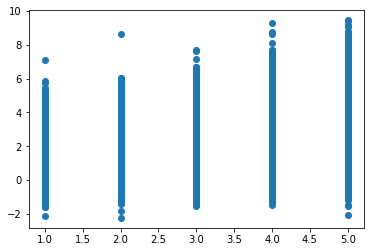

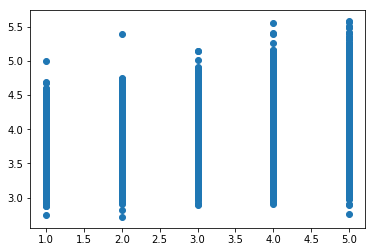

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(y, y_pred)
plt.show()
plt.scatter(y, y_pred1)
plt.show()

    in sample  out of sample

1:   3.02772565908     3.02876016098

5:   2.79278816279     2.81172254516

10:  2.69185937661     2.71344419387

20:  2.59488662126     2.64039379375

improvement via linear regression: test error reduced to 1.04462151344 with K = 20